<a href="https://colab.research.google.com/github/Subh37106/Code-Gen-From-UDB-to-Implementations/blob/main/Case_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1. Environment Setup and Raw Data GenerationWe generate a synthetic GPS trajectory dataset. Each trip is represented by a feature vector $traj_i$ containing spatial coordinates, path length, and turn frequency.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

np.random.seed(42)

n_trips = 250
data = {
    'trip_id': range(1, n_trips + 1),
    'origin_lat': np.random.uniform(34.0, 34.1, n_trips),
    'origin_lon': np.random.uniform(-118.3, -118.2, n_trips),
    'dest_lat': np.random.uniform(34.2, 34.3, n_trips),
    'dest_lon': np.random.uniform(-118.5, -118.4, n_trips),
    'path_length_km': np.random.uniform(5.0, 25.0, n_trips),
    'turn_freq': np.random.uniform(0.5, 3.5, n_trips)
}

df_raw = pd.DataFrame(data)

print("--- RAW TRAJECTORY DATASET ---")
print(df_raw.head())

--- RAW TRAJECTORY DATASET ---
   trip_id  origin_lat  origin_lon   dest_lat    dest_lon  path_length_km  \
0        1   34.037454 -118.270555  34.269816 -118.488310        8.702659   
1        2   34.095071 -118.261490  34.253610 -118.406017       15.838019   
2        3   34.073199 -118.214886  34.230953 -118.437229       22.458917   
3        4   34.059866 -118.268308  34.281380 -118.466509       19.644498   
4        5   34.015602 -118.283051  34.268473 -118.486073       21.131223   

   turn_freq  
0   2.889612  
1   1.944567  
2   0.851925  
3   0.875557  
4   2.556696  


2. 01 Map Matching and Path Embedding
We prepare the features for clustering. In real scenarios, this involves snapping coordinates to a road network. Here, we standardize the numerical embeddings.

In [2]:
features = ['origin_lat', 'origin_lon', 'dest_lat', 'dest_lon', 'path_length_km', 'turn_freq']
X = df_raw[features]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

3. Determining Optimal K: The Elbow Method
We use the Elbow Method to find the natural number of trip clusters (e.g., Standard Commute vs. Local Delivery).

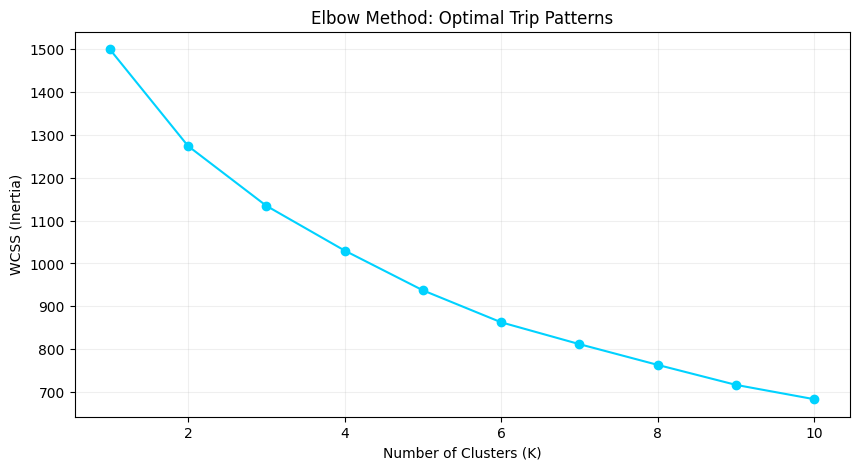

In [3]:
wcss = []
k_range = range(1, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, init='k-means++', n_init=10, random_state=42)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(10, 5))
plt.plot(k_range, wcss, marker='o', color='#00d2ff')
plt.title('Elbow Method: Optimal Trip Patterns')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('WCSS (Inertia)')
plt.grid(alpha=0.2)
plt.show()

4. 02 & 03 Clustering (K=4) and Detection: Based on the elbow and case study requirements, we apply K-Means with $K=4$ to identify common corridors.

In [4]:
kmeans = KMeans(n_clusters=4, init='k-means++', n_init=10, random_state=42)
df_raw['cluster'] = kmeans.fit_predict(X_scaled)

pattern_map = {
    0: 'Standard Commute',
    1: 'Alternative Route',
    2: 'Local/Delivery',
    3: 'Long Haul'
}
df_raw['Pattern'] = df_raw['cluster'].map(pattern_map)

print("\n--- TRAJECTORY CLUSTERING RESULTS ---")
print(df_raw[['trip_id', 'Pattern', 'path_length_km', 'turn_freq']].head(10))


--- TRAJECTORY CLUSTERING RESULTS ---
   trip_id            Pattern  path_length_km  turn_freq
0        1   Standard Commute        8.702659   2.889612
1        2     Local/Delivery       15.838019   1.944567
2        3     Local/Delivery       22.458917   0.851925
3        4   Standard Commute       19.644498   0.875557
4        5  Alternative Route       21.131223   2.556696
5        6          Long Haul       18.175667   1.790918
6        7  Alternative Route       18.845531   1.101574
7        8     Local/Delivery       21.983913   1.974784
8        9   Standard Commute        9.993360   0.692627
9       10     Local/Delivery       14.788499   2.245914


5. Visualization: Trajectory Pattern Detection
We visualize the spatial similarity by plotting path length against turn frequency to see distinct route choices.

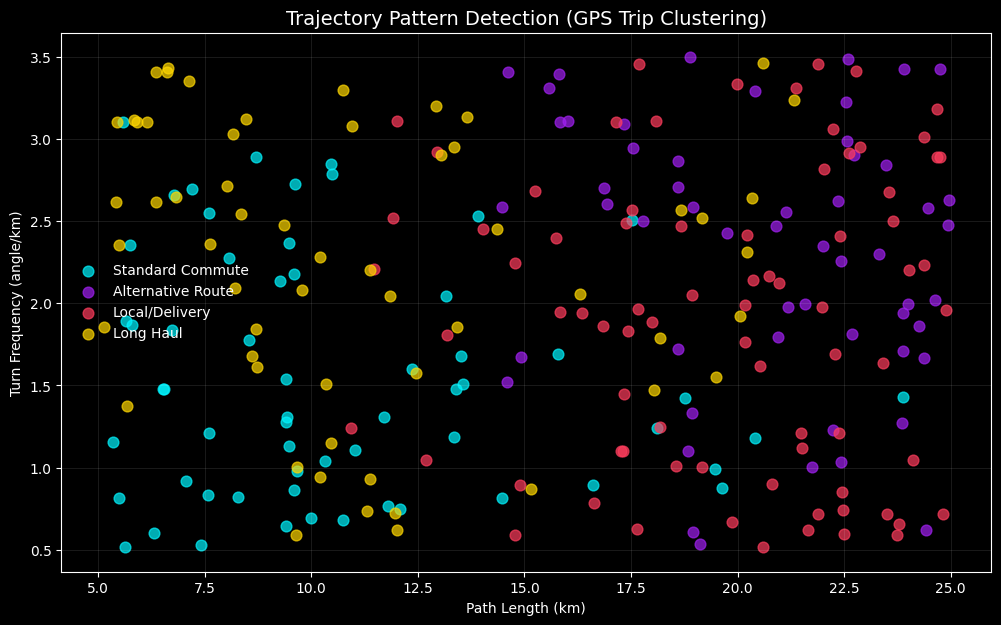

In [5]:
plt.style.use('dark_background')
plt.figure(figsize=(12, 7))

colors = {'Standard Commute': '#00F5FF', 'Alternative Route': '#A020F0', 'Local/Delivery': '#FF3D5D', 'Long Haul': '#FFD700'}

for pattern, color in colors.items():
    subset = df_raw[df_raw['Pattern'] == pattern]
    plt.scatter(subset['path_length_km'], subset['turn_freq'], c=color, label=pattern, alpha=0.7, s=60)

plt.title('Trajectory Pattern Detection (GPS Trip Clustering)', fontsize=14)
plt.xlabel('Path Length (km)')
plt.ylabel('Turn Frequency (angle/km)')
plt.legend(frameon=False)
plt.grid(alpha=0.1)
plt.show()

Summary of Results:
Path Embedding: Converted variable-length GPS data into fixed-size feature vectors for clustering.Optimal K: The Elbow Method validated $K=4$, effectively distinguishing between standard commutes and specialized delivery routes.Applications: These results support Route Prediction, Driver Profiling, and identifying Demand Hotspots.